In [33]:
import pandas as pd
import numpy as np
import itertools
from prophet import Prophet
import matplotlib.pyplot as plt
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_plotly
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Load data
data = pd.read_excel(r"C:\Users\Admin\WORK\Time_series_analysis\data\task_1_2.xlsx", sheet_name="Timeseries")
data = data.rename(columns={'Date': 'ds', 'series1': 'y'})
data['ds'] = pd.to_datetime(data['ds'])                        # change to datetime object (datetime64)                             

In [3]:
print(data.head())
print(data.info())

          ds            y
0 2015-01-01  1006.699649
1 2015-01-02  3197.751826
2 2015-01-03  3217.491035
3 2015-01-04  2151.573759
4 2015-01-05  4243.929892
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642 entries, 0 to 1641
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1642 non-null   datetime64[ns]
 1   y       1642 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 25.8 KB
None


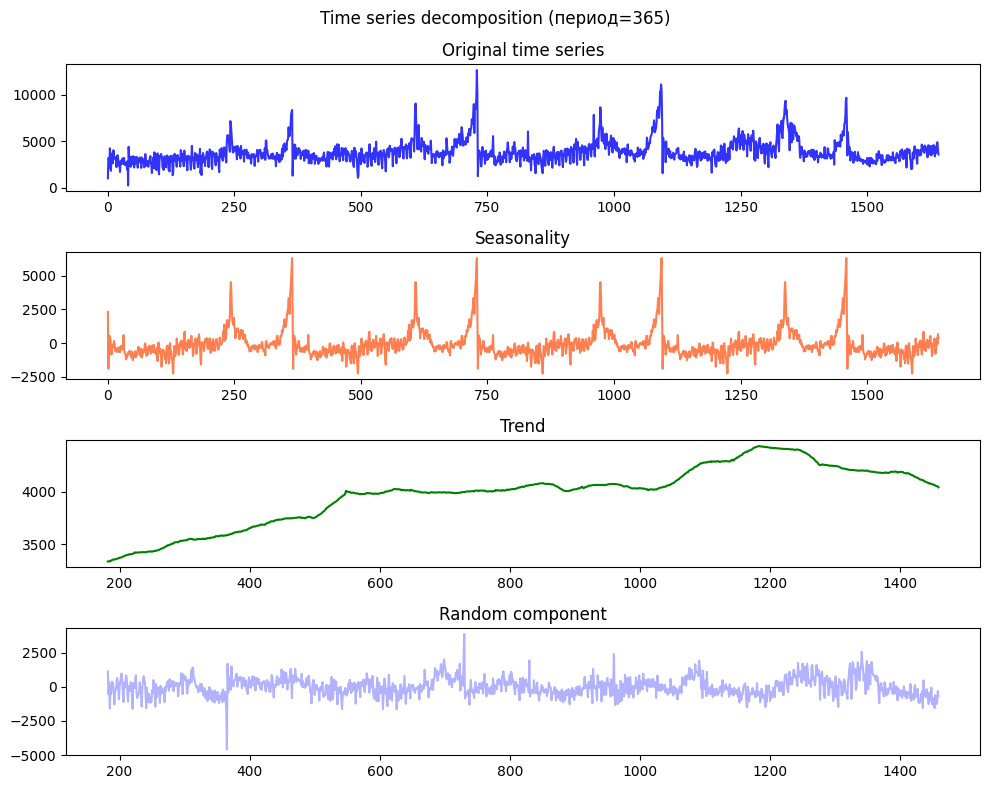

In [4]:
def decompose(series, period):
    
    decomposition = seasonal_decompose(series, period=period, model='additive')
    fig, axs = plt.subplots(4, 1, figsize=(10, 8))

    axs[0].plot(series, color='blue', alpha=0.8)
    axs[0].set_title('Original time series')

    axs[1].plot(decomposition.seasonal, color='coral')
    axs[1].set_title('Seasonality')

    axs[2].plot(decomposition.trend, color='green')
    axs[2].set_title('Trend')

    axs[3].plot(decomposition.resid, color='blue', alpha=0.3)
    axs[3].set_title('Random component')

    plt.suptitle(f"Time series decomposition (период={period})")
    plt.tight_layout()
    plt.show()


decompose(data.y, period=365)

In [5]:
data_train = data[data["ds"] <= "2019-04"]
data_test = data[data["ds"] > "2019-04"]
print(len(data_train), len(data_test))

1552 90


In [6]:
cutoffs = pd.to_datetime(["2017-09-30", "2018-03-30", "2018-09-30", "2019-03-30"])

param_grid = {
    "changepoint_prior_scale": [0.0009, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
    "seasonality_prior_scale": [0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 3.0],
}
# Generate all combinations of parameters
all_params = [
    dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())
]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(data)  # Fit model with given params
    df_cv = cross_validation(
        m, cutoffs=cutoffs, horizon="90 days", parallel="processes"
    )
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p["rmse"].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results["rmse"] = rmses
print(tuning_results)

13:22:41 - cmdstanpy - INFO - Chain [1] start processing
13:22:41 - cmdstanpy - INFO - Chain [1] done processing
13:22:43 - cmdstanpy - INFO - Chain [1] start processing
13:22:43 - cmdstanpy - INFO - Chain [1] done processing
13:22:45 - cmdstanpy - INFO - Chain [1] start processing
13:22:45 - cmdstanpy - INFO - Chain [1] done processing
13:22:47 - cmdstanpy - INFO - Chain [1] start processing
13:22:47 - cmdstanpy - INFO - Chain [1] done processing
13:22:49 - cmdstanpy - INFO - Chain [1] start processing
13:22:49 - cmdstanpy - INFO - Chain [1] done processing
13:22:51 - cmdstanpy - INFO - Chain [1] start processing
13:22:51 - cmdstanpy - INFO - Chain [1] done processing
13:22:53 - cmdstanpy - INFO - Chain [1] start processing
13:22:53 - cmdstanpy - INFO - Chain [1] done processing
13:22:55 - cmdstanpy - INFO - Chain [1] start processing
13:22:55 - cmdstanpy - INFO - Chain [1] done processing
13:22:57 - cmdstanpy - INFO - Chain [1] start processing
13:22:57 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale         rmse
0                    0.0009                    0.001  1354.826363
1                    0.0009                    0.005  1060.047921
2                    0.0009                    0.010  1020.448627
3                    0.0009                    0.050  1025.283677
4                    0.0009                    0.100  1065.349374
5                    0.0009                    1.000  1031.456439
6                    0.0009                    3.000  1026.230581
7                    0.0010                    0.001  1326.784431
8                    0.0010                    0.005  1010.994875
9                    0.0010                    0.010  1028.989906
10                   0.0010                    0.050  1030.406380
11                   0.0010                    0.100  1021.762889
12                   0.0010                    1.000  1037.658590
13                   0.0010                    3.000  1041.410119
14        

In [7]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.005}


In [8]:
model_1 = Prophet(interval_width=0.95)        # default
model_1.fit(data_train)

model_2 = Prophet(                            # with Hyperparameter tuning
    interval_width=0.95,
    changepoint_prior_scale=0.001,
    seasonality_prior_scale=0.005,
)
model_2.fit(data_train)

model_3 = Prophet(
    interval_width=0.95,
    changepoint_prior_scale=0.004,
    seasonality_prior_scale=0.07,
)
model_3.fit(data_train)




13:25:59 - cmdstanpy - INFO - Chain [1] start processing
13:26:00 - cmdstanpy - INFO - Chain [1] done processing
13:26:00 - cmdstanpy - INFO - Chain [1] start processing
13:26:00 - cmdstanpy - INFO - Chain [1] done processing
13:26:00 - cmdstanpy - INFO - Chain [1] start processing
13:26:01 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
# create dataframe for test  and  predict
future_dates = model_1.make_future_dataframe(
    periods=180, freq="D", include_history=True
)
future_dates

,ds
0,2015-01-01
1,2015-01-02
2,2015-01-03
3,2015-01-04
4,2015-01-05
...,...
1727,2019-09-24
1728,2019-09-25
1729,2019-09-26
1730,2019-09-27


In [10]:
forecast_1 = model_1.predict(future_dates)
forecast_2 = model_2.predict(future_dates)
forecast_3 = model_3.predict(future_dates)
print(forecast_3[["ds", "yhat", "yhat_lower", "yhat_upper"]])

             ds         yhat   yhat_lower   yhat_upper
0    2015-01-01  5232.531335  3616.288072  6922.452226
1    2015-01-02  5068.471739  3402.520783  6611.363567
2    2015-01-03  4523.828535  2813.363261  6144.140936
3    2015-01-04  3740.169029  2221.678953  5361.109473
4    2015-01-05  4431.253132  2798.639774  6028.445262
...         ...          ...          ...          ...
1727 2019-09-24  4725.589482  3163.191130  6324.798286
1728 2019-09-25  4735.539225  3139.865010  6436.943840
1729 2019-09-26  4679.718846  3195.211044  6197.809154
1730 2019-09-27  4668.573915  3174.577940  6215.701873
1731 2019-09-28  4291.731913  2614.591045  5923.322558

[1732 rows x 4 columns]


C:\Users\Admin\AppData\Local\Temp\ipykernel_7108\2634010558.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test["ds"] = pd.to_datetime(data_test["ds"])


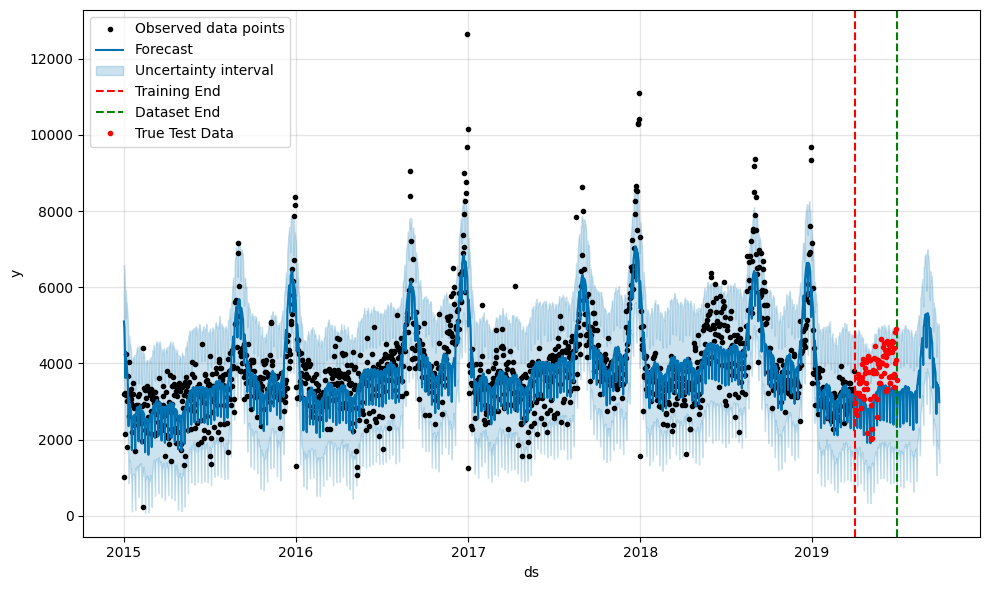

In [ ]:
# plot train, test and predict data
forecast_plot = model_1.plot(forecast_1)
# add a vertical line at the end of the training period
axes = forecast_plot.gca()
last_training_date = forecast_1["ds"].iloc[-180]
last_date = forecast_1["ds"].iloc[-90]
axes.axvline(x=last_training_date, color="red", linestyle="--", label="Training End")
axes.axvline(x=last_date, color="green", linestyle="--", label="Dataset End")
# plot true test data for the period after the red line
data_test["ds"] = pd.to_datetime(data_test["ds"])
plt.plot(data_test["ds"], data_test["y"], "ro", markersize=3, label="True Test Data")

# show the legend to distinguish between the lines
plt.legend()

C:\Users\Admin\AppData\Local\Temp\ipykernel_7052\259904435.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test["ds"] = pd.to_datetime(data_test["ds"])


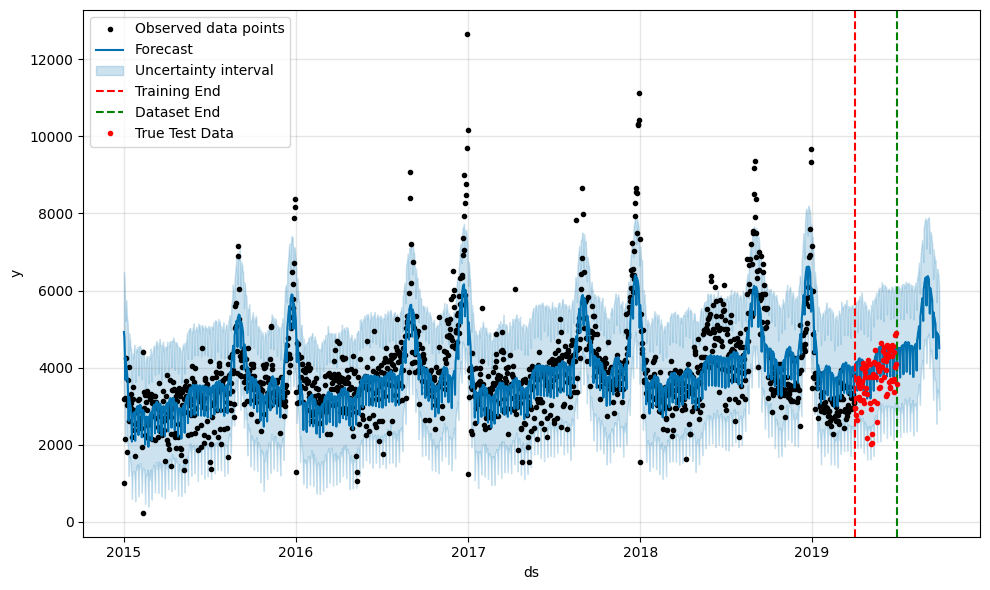

In [13]:
# plot train, test and predict data
forecast_plot = model_2.plot(forecast_2)
# add a vertical line at the end of the training period
axes = forecast_plot.gca()
last_training_date = forecast_2["ds"].iloc[-180]
last_date = forecast_2["ds"].iloc[-90]
axes.axvline(x=last_training_date, color="red", linestyle="--", label="Training End")
axes.axvline(x=last_date, color="green", linestyle="--", label="Dataset End")
# plot true test data for the period after the red line
data_test["ds"] = pd.to_datetime(data_test["ds"])
plt.plot(data_test["ds"], data_test["y"], "ro", markersize=3, label="True Test Data")

# show the legend to distinguish between the lines
plt.legend()

C:\Users\Admin\AppData\Local\Temp\ipykernel_7052\2071085948.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test["ds"] = pd.to_datetime(data_test["ds"])


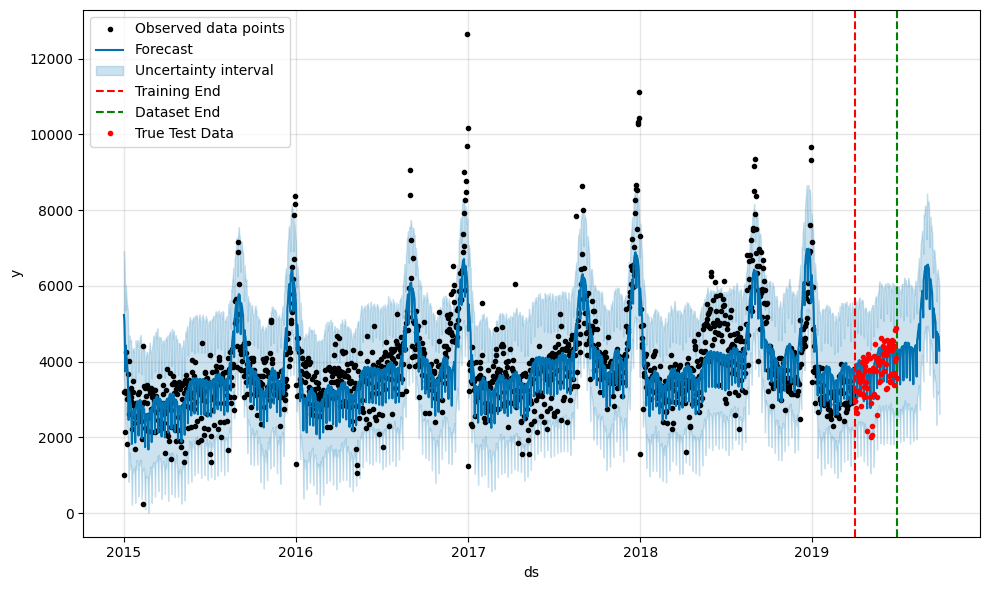

In [14]:
# plot train, test and predict data
forecast_plot = model_3.plot(forecast_3)
# add a vertical line at the end of the training period
axes = forecast_plot.gca()
last_training_date = forecast_3["ds"].iloc[-180]
last_date = forecast_3["ds"].iloc[-90]
axes.axvline(x=last_training_date, color="red", linestyle="--", label="Training End")
axes.axvline(x=last_date, color="green", linestyle="--", label="Dataset End")
# plot true test data for the period after the red line
data_test["ds"] = pd.to_datetime(data_test["ds"])
plt.plot(data_test["ds"], data_test["y"], "ro", markersize=3, label="True Test Data")

# show the legend to distinguish between the lines
plt.legend()

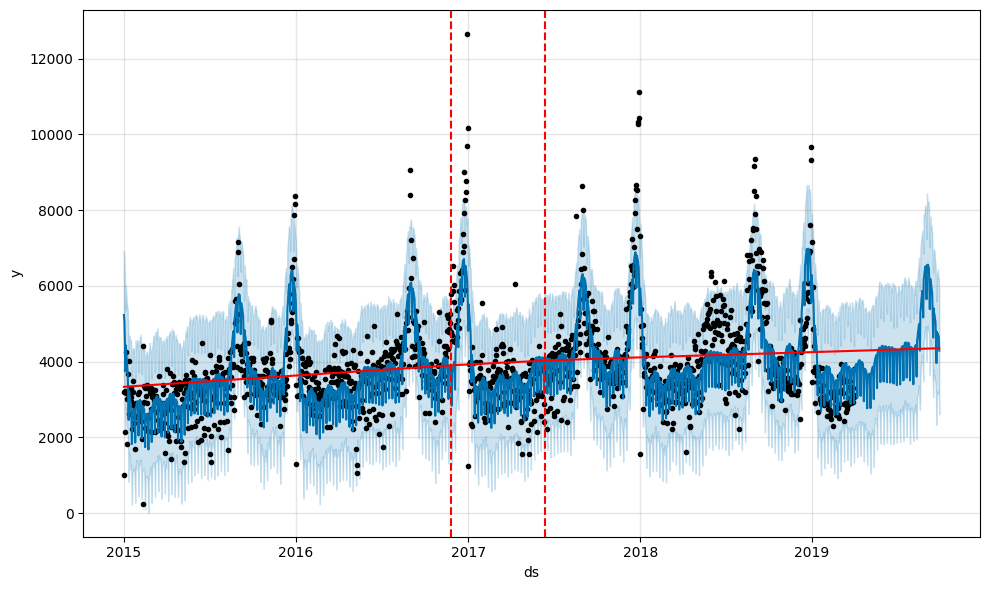

In [15]:
# Check count of trend points
fig = model_3.plot(forecast_3)
point = add_changepoints_to_plot(fig.gca(), model_3, forecast_3)

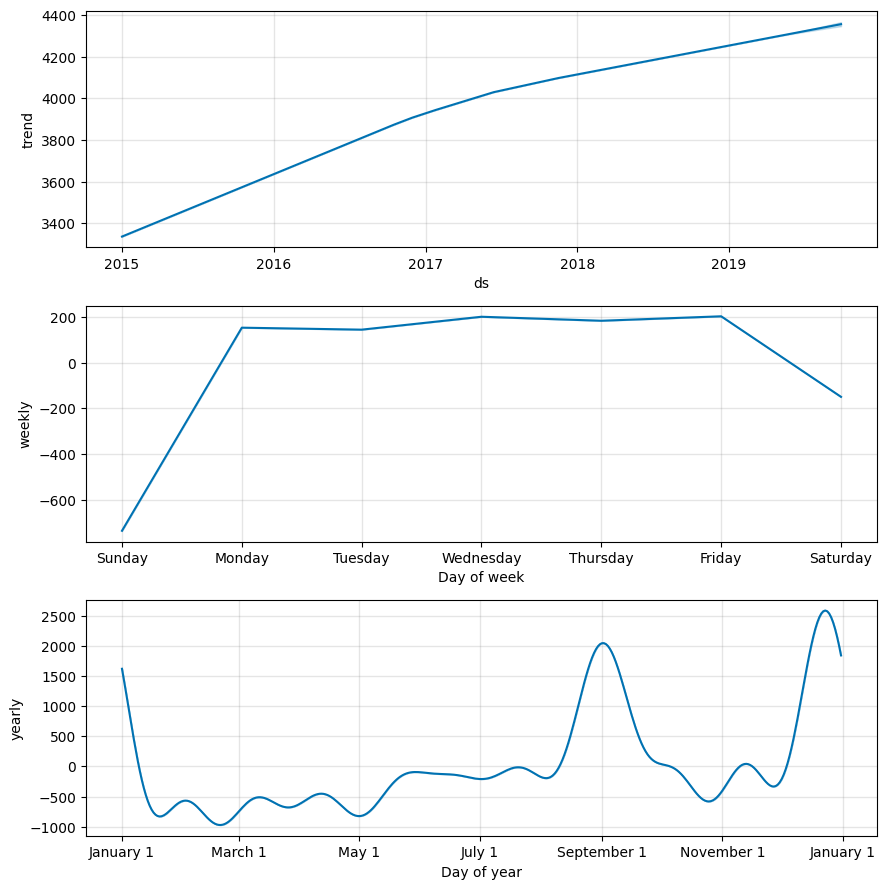

In [16]:
# Plot components of time series
decompos = model_3.plot_components(forecast_3)

In [20]:
# interactive display of time series
plot_plotly(model_3, forecast_3)

In [36]:
# Calculate MAPE
data_predict_1 = forecast_1["yhat"].iloc[1552:1642]
data_predict_2 = forecast_2["yhat"].iloc[1552:1642]
data_predict_3 = forecast_3["yhat"].iloc[1552:1642]
test = data_test["y"]
mape_1 = mean_absolute_percentage_error(test, data_predict_1)
mape_2 = mean_absolute_percentage_error(test, data_predict_2)
mape_3 = mean_absolute_percentage_error(test, data_predict_3)
rmse_3 = root_mean_squared_error(test, data_predict_3)
r2 = r2_score(test, data_predict_3)
print(f"Mean Absolute Percentage Error (Model_1): {mape_1:.2f}")
print(f"Mean Absolute Percentage Error (Model_2): {mape_2:.2f}")
print(f"Mean Absolute Percentage Error (Model_3): {mape_3:.2f}")
print(f"Root_mean_squared_error (Model_3): {rmse_3:.2f}")
print(f"r2_score (Model_3): {r2:.2f}")

Mean Absolute Percentage Error (Model_1): 0.20
Mean Absolute Percentage Error (Model_2): 0.16
Mean Absolute Percentage Error (Model_3): 0.13
Root_mean_squared_error (Model_3): 535.44
r2_score (Model_3): 0.24


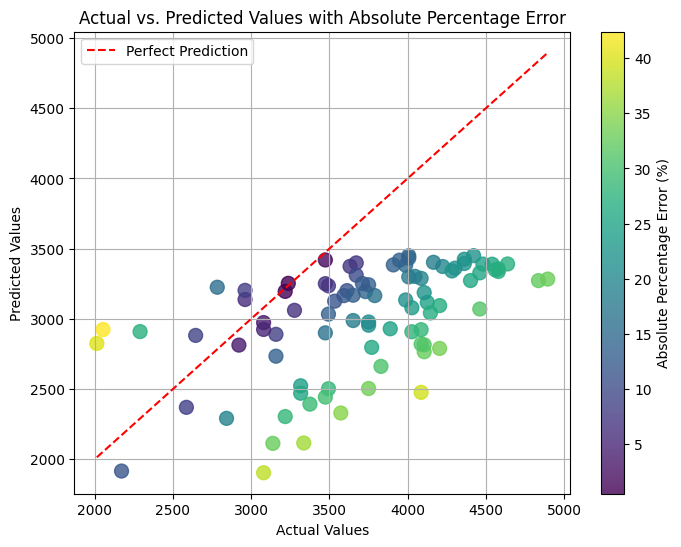

In [18]:
# Calculate individual absolute percentage errors for visualization
abs_percentage_errors_1 = np.abs((test - data_predict_1) / test) * 100

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(
    test, data_predict_1, c=abs_percentage_errors_1, cmap="viridis", s=100, alpha=0.8
)
plt.colorbar(label="Absolute Percentage Error (%)")
plt.plot(
    [min(test), max(test)], [min(test), max(test)], "r--", label="Perfect Prediction"
)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values with Absolute Percentage Error")
plt.legend()
plt.grid(True)
plt.show()

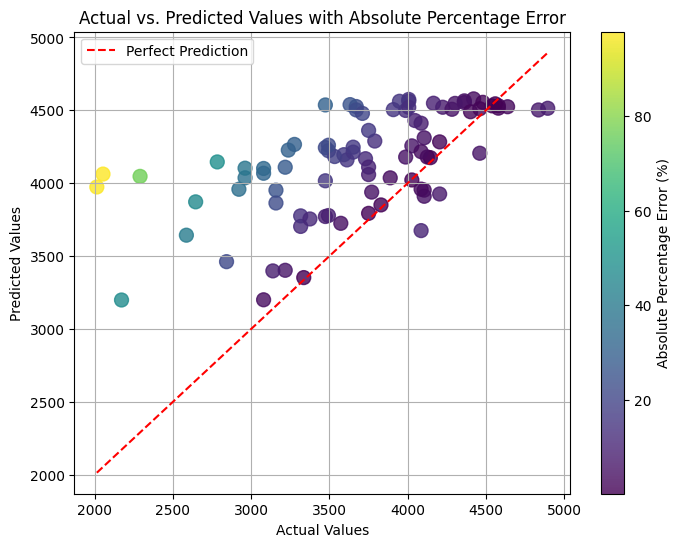

In [20]:
# Calculate individual absolute percentage errors for visualization
abs_percentage_errors_2 = np.abs((test - data_predict_2) / test) * 100

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(
    test, data_predict_2, c=abs_percentage_errors_2, cmap="viridis", s=100, alpha=0.8
)
plt.colorbar(label="Absolute Percentage Error (%)")
plt.plot(
    [min(test), max(test)], [min(test), max(test)], "r--", label="Perfect Prediction"
)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values with Absolute Percentage Error")
plt.legend()
plt.grid(True)
plt.show()

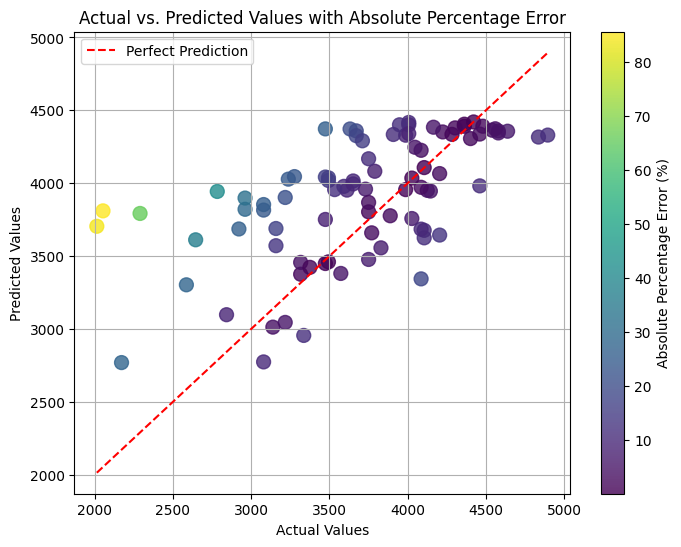

In [19]:
# Calculate individual absolute percentage errors for visualization
abs_percentage_errors_3 = np.abs((test - data_predict_3) / test) * 100

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(
    test, data_predict_3, c=abs_percentage_errors_3, cmap="viridis", s=100, alpha=0.8
)
plt.colorbar(label="Absolute Percentage Error (%)")
plt.plot(
    [min(test), max(test)], [min(test), max(test)], "r--", label="Perfect Prediction"
)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values with Absolute Percentage Error")
plt.legend()
plt.grid(True)
plt.show()

In [37]:
data_predict = forecast_3.rename(columns={"ds": "date", "yhat": "value"})
data_predict = data_predict[["date", "value"]].iloc[1642:]
data_predict = data_predict.set_index("date")
data_predict

,value
date,
2019-07-01,4267.829687
2019-07-02,4257.859436
2019-07-03,4314.923756
2019-07-04,4299.927511
2019-07-05,4324.122669
...,...
2019-09-24,4725.589482
2019-09-25,4735.539225
2019-09-26,4679.718846


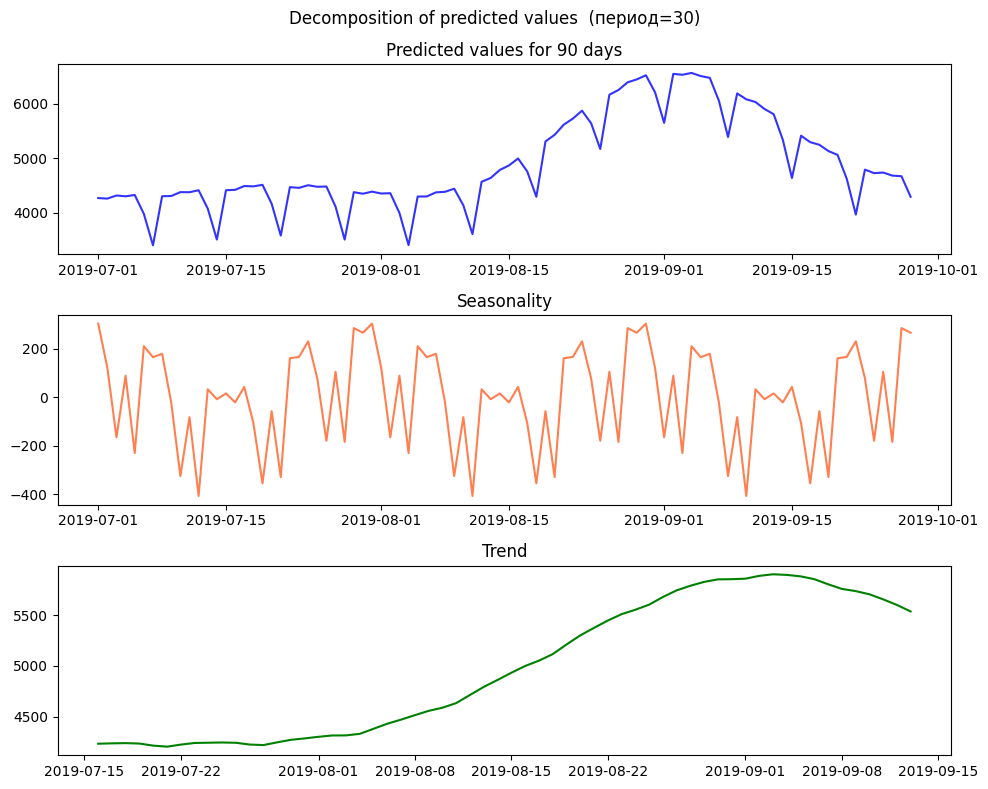

In [39]:
def decompose(series, period):
    decomposition = seasonal_decompose(series, period=period, model="additive")

    fig, axs = plt.subplots(3, 1, figsize=(10, 8))

    axs[0].plot(series, color="blue", alpha=0.8)
    axs[0].set_title("Predicted values for 90 days")

    axs[1].plot(decomposition.seasonal, color="coral")
    axs[1].set_title("Seasonality")

    axs[2].plot(decomposition.trend, color="green")
    axs[2].set_title("Trend")

    plt.suptitle(f"Decomposition of predicted values  (период={period})")
    plt.tight_layout()
    plt.show()


decompose(data_predict.value, period=30)

In [41]:
data_predict.describe()

,value
count,90.000000
mean,4877.151267
std,848.250147
min,3400.214105
25%,4317.223485
50%,4538.314492
75%,5423.891293
max,6564.048753
